In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy
from cgi_phasec_poppy.imshows import *
from cgi_phasec_poppy.math_module import xp
reload(cgi_phasec_poppy)
data_dir = cgi_phasec_poppy.data_dir

iwa = 6
owa = 20

wavelength_c = 825e-9*u.m

polaxis = [-2, -1, 1, 2]
npol = len(polaxis)


In [9]:
params.update({'polaxis':1})

In [2]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

params = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
}

actors = []
for i in range(npol):
    params.update({'polaxis':polaxis[i]})
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**params))

2023-10-24 14:01:36,405	INFO worker.py:1636 -- Started a local Ray instance.


# Without noise

(CGI pid=1646243) 0.1 0.0072010264910560605 arcsec / pix


(CGI pid=1646243) After resampling, optic phasor shape (1045, 1045) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(CGI pid=1646246) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=1646246)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


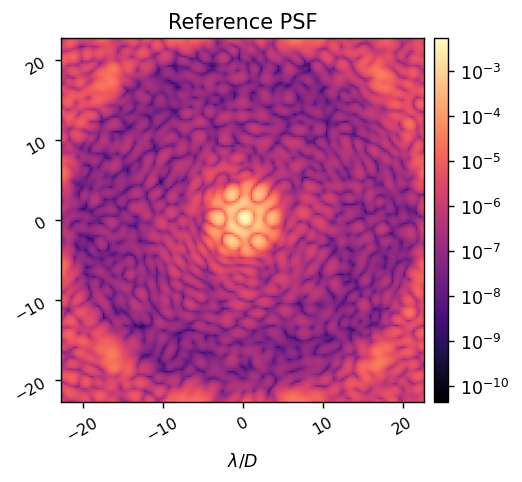

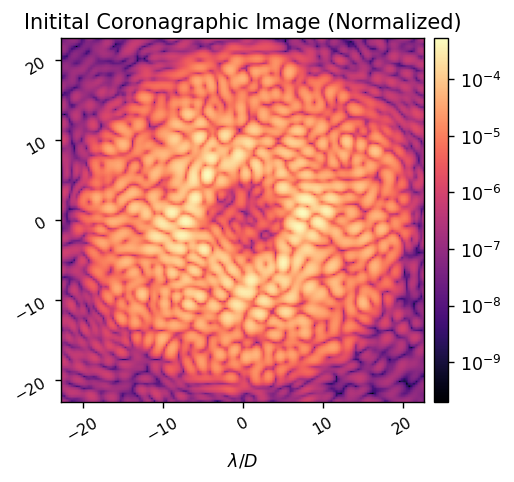

In [3]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, )

max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref

mode.set_actor_attr('use_fpm',True)

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True,)


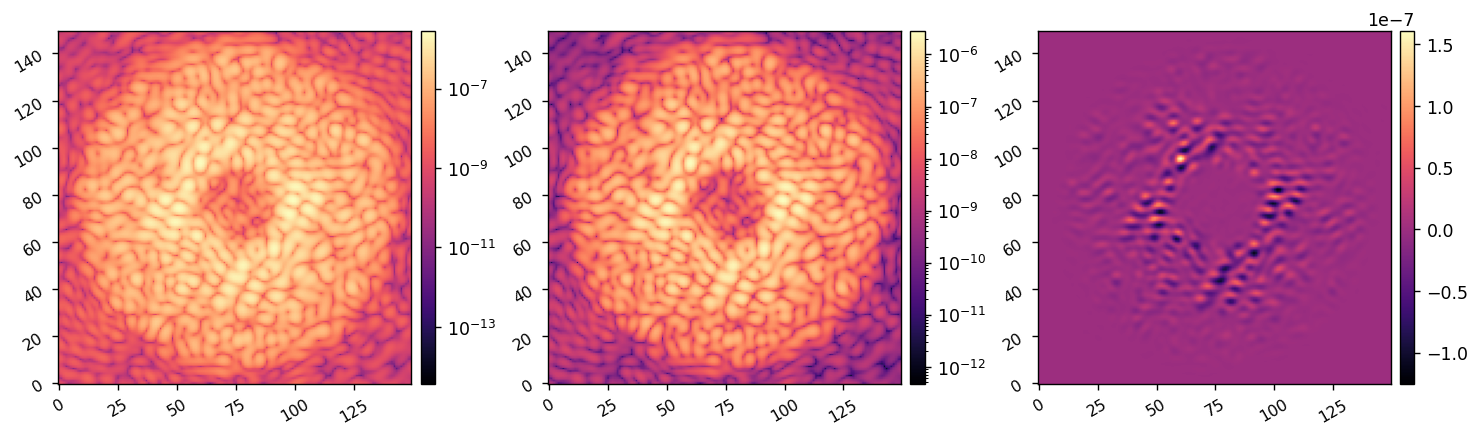

In [5]:
imshow3(xp.abs(psfs[0])**2, xp.abs(psfs[1])**2, xp.abs(psfs[0])**2-xp.abs(psfs[1])**2,
        lognorm1=True, lognorm2=True)